Out of sync by 0
1,--- 8.908066987991333 seconds ---


C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:261: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
C:\Users\jsrinivas\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


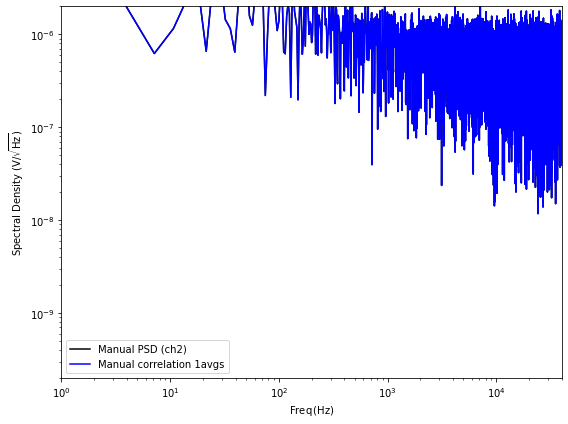

In [1]:
import time
import zhinst.utils
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import signal
import datetime
import os

dev_name = 'GS4_0DC_05'
scope_time = 8
sample_rate = 60e6/2**scope_time
j = 16
num_samples = 2**j

d = datetime.date.today()
date_ = d.strftime("%Y%m%d")
data_path = "C:\\Users\\jsrinivas\\" + date_ ###### Change directory here  ######
if not os.path.exists(data_path): os.mkdir(data_path)
data_path = data_path + "\\" +  dev_name
if not os.path.exists(data_path): os.mkdir(data_path)

now_time = datetime.datetime.now()

data_name0 = dev_name + '_' \
            + str(sample_rate) + 'Hz_' + str(num_samples) + '_NS_' + now_time.strftime("%H_%M_%S")

repeats = int(1e3)

stop = float(sample_rate)/2.0
step = 1/(num_samples/float(sample_rate))

start_time = time.time()

############# configure MFLI #################

scope_in_channel = 0
apilevel = 6

daq =  zhinst.ziPython.ziDAQServer('127.0.0.1', 8004, apilevel)
zhinst.utils.api_server_version_check(daq)
discovery = zhinst.ziPython.ziDiscovery()

# Enable the API's log.
daq.setDebugLevel(3)

## Master and slave device ID
master_id = 'dev2521' ###### Change master device here  ######
slave_id = 'dev2521' ###### Change slave here  ######
master = discovery.find(master_id).lower()
slave = discovery.find(slave_id).lower()


####################################################################################################################
# Configure the scope and obtain data with triggering disabled.
####################################################################################################################

# 'length' : the length of each segment
daq.setInt('/%s/scopes/0/length' % master_id, num_samples)
daq.setInt('/%s/scopes/0/length' % slave_id, num_samples)

# 0 to enable scope channels for both devices
daq.setInt('/%s/scopes/0/channel' % master_id, 0)
daq.setInt('/%s/scopes/0/channel' % slave_id, 0)

#   1 to bandwidth limit scope data (avoids antialiasing effects)
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (master_id, scope_in_channel), 1)
daq.setInt('/%s/scopes/0/channels/%d/bwlimit' % (slave_id, scope_in_channel), 1)

#   Selects scope channel input as 0 : signal input 1
scope_inputselect=0 
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (master_id, scope_in_channel), scope_inputselect)
daq.setInt('/%s/scopes/0/channels/%d/inputselect' % (slave_id, scope_in_channel), scope_inputselect)

# timebase for acquisition of record
daq.setInt('/%s/scopes/0/time' % master_id, scope_time)
daq.setInt('/%s/scopes/0/time' % slave_id, scope_time)


#   0 - acquire continuous records
daq.setInt('/%s/scopes/0/single' % master_id, 0)
daq.setInt('/%s/scopes/0/single' % slave_id, 0)

#   1 - only acquire a record when a trigger arrives (important!)
daq.setInt('/%s/scopes/0/trigenable' % master_id, 1)
daq.setInt('/%s/scopes/0/trigenable' % slave_id, 1)
# 'trigholdoff' : the scope hold off time inbetween acquiring triggers (still relevant if triggering is disabled).
scope_trigholdoff=0.050
daq.setDouble('/%s/scopes/0/trigholdoff' % master_id, scope_trigholdoff)
daq.setDouble('/%s/scopes/0/trigholdoff' % slave_id, scope_trigholdoff)
# 'segments/enable' : Disable segmented data recording.
daq.setInt('/%s/scopes/0/segments/enable' % master_id, 0)
daq.setInt('/%s/scopes/0/segments/enable' % slave_id, 0)

# Global synchronisation between devices
daq.sync()

# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()


# 1 - Scope data processing mode
scopeModule.set('scopeModule/mode', 1)


#   weight=1 - don't average.
scopeModule.set('scopeModule/averager/weight', 1)

# Module history length for scopeModule handle
scopeModule.set('scopeModule/historylength', 10)

# Subscribe to the scope's data in the module.
wave_nodepath_master = '/{}/scopes/0/wave'.format(master)
scopeModule.subscribe(wave_nodepath_master)
wave_nodepath_slave = '/{}/scopes/0/wave'.format(slave)
scopeModule.subscribe(wave_nodepath_slave)

sync = 0
time_delta = 20 # time shift between traces
daq.setInt('/%s/scopes/0/enable' % master, 1)
daq.setInt('/%s/scopes/0/enable' % slave, 1)
    
while not sync:
    
    daq.sync()
    
    num_records = 20
    start = time.time()
    timeout = 30  # [s]
    records = 0
    progress = 0
    # Wait until the Scope Module has received and processed the desired number of records.
    data_fft = ['0', '0']
    while (wave_nodepath_master not in data_fft) or (wave_nodepath_slave not in data_fft):
        scopeModule.execute()
        while ((records < num_records) or (progress < 1.0)):
            time.sleep(0.5)
            records = scopeModule.getInt('scopeModule/records')
            progress = scopeModule.progress()[0]
            if (time.time() - start) > timeout:
                # Break out of the loop if for some reason we're no longer receiving scope data from the device.
                print("\nScope Module did not return {} records after {} s - forcing stop.".format(num_records, timeout))
                break

            
    # Read out the scope data from the module.
        data_fft = scopeModule.read(True)
    out_of_sync = np.abs(data_fft[wave_nodepath_master][0][0]['timestamp'] - data_fft[wave_nodepath_slave][0][0]['timestamp'])
    #print data_fft[wave_nodepath_master][0][0]['timestamp']
    print("Out of sync by " + str(out_of_sync))
    if out_of_sync > time_delta:
        daq.setInt('/%s/scopes/0/enable' % master, 0)
        daq.setInt('/%s/scopes/0/enable' % slave, 0)
        time.sleep(1)
        daq.setInt('/%s/scopes/0/enable' % master, 1)
        daq.setInt('/%s/scopes/0/enable' % slave, 1)
    else: sync = 1

counter = (1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000)# int(1e0)

for n in range (1, repeats+1):
     ##########################
     # begin loop #############
     ##########################

    sync = 0

    while not sync:
        
        daq.sync()
        
        num_records = 20
        start = time.time()
        timeout = 30  # [s]
        records = 0
        progress = 0
        # Wait until the Scope Module has received and processed the desired number of records.
        data_fft = ['0', '0']
        while (wave_nodepath_master not in data_fft) or (wave_nodepath_slave not in data_fft):
            scopeModule.execute()
            while ((records < num_records) or (progress < 1.0)):
                time.sleep(0.5)
                records = scopeModule.getInt('scopeModule/records')
                progress = scopeModule.progress()[0]

                if (time.time() - start) > timeout:
                    # Break out of the loop if for some reason we're no longer receiving scope data from the device.
                    print("\nScope Module did not return {} records after {} s - forcing stop.".format(num_records, timeout))
                    break
    
        
        # Read out the scope data from the module.
            data_fft = scopeModule.read(True)
        
    # Stop the module; to use it again we need to call execute().
    
    
        assert wave_nodepath_master in data_fft, "The Scope Module did not return data for {}.".format(wave_nodepath_master)
        assert wave_nodepath_master in data_fft, "The Scope Module did not return data for {}.".format(wave_nodepath_slave)
        out_of_sync = np.abs(data_fft[wave_nodepath_master][0][0]['timestamp'] - data_fft[wave_nodepath_slave][0][0]['timestamp'])

        if out_of_sync < time_delta: sync = 1
        else:
            print("Out of sync by " + str(out_of_sync)),
    
    
    wave_master = data_fft[wave_nodepath_master][0][0]['wave'][0]
    wave_slave = data_fft[wave_nodepath_slave][0][0]['wave'][0]
    
    data = [wave_master, wave_slave]
    data[0] = data[0]-np.mean(data[0])
    data[1] = data[1]-np.mean(data[1])

    data_fft_0 = 2*np.fft.fft(scipy.signal.windows.hann(len(data[0]))*(data[0]), norm=None)/ len(data[0]) #fft of channel 1
    data_fft_1 = 2*np.fft.fft(scipy.signal.windows.hann(len(data[1]))*(data[1]), norm=None)/ len(data[1])  #fft of channel 1
    

    if n == 1: 
        data_fft_0_sum = data_fft_0 #create sum on first iteration
        data_fft_1_sum = data_fft_1 #create sum on first iteration
        
        corr_fft = np.multiply(data_fft_0, np.conj(data_fft_1)) #multiply fft chan 1 by complex comjugate of fft for chan 2
        
        data_psd_0 = 2*np.multiply(data_fft_0, np.conj(data_fft_0))[:int(len(data_fft_0)/2)] / step # calculate PSD for chan 1
        data_psd_1 = 2*np.multiply(data_fft_1, np.conj(data_fft_1))[:int(len(data_fft_1)/2)] / step # calculate PSD for chan 2
        
    else:
        data_fft_0_sum = data_fft_0_sum + data_fft_0 # sum ffts
        data_fft_1_sum = data_fft_1_sum + data_fft_1 # sum ffts
        
        corr_fft = corr_fft + np.multiply(data_fft_0, np.conj(data_fft_1)) # sum correlated fft with newly calculated correlated fft
        
        data_psd_0 = data_psd_0 + 2*np.multiply(data_fft_0, np.conj(data_fft_0))[:int(len(data_fft_0)/2)] / step # sum PSD chan 1 with new PSD for chan 1
        data_psd_1 = data_psd_1 + 2*np.multiply(data_fft_1, np.conj(data_fft_1))[:int(len(data_fft_1)/2)] / step # sum PSD chan 2 with new PSD for chan 2
    
    print(str(n) + ',', end='')

    
     ##########################
     # end   loop #############
     ##########################


    if n in counter:
        data_name = data_name0 + '_' + str(n)
        manual_corr = np.sqrt(2*np.sqrt(np.multiply(corr_fft/float(n), 
                                        np.conj(corr_fft/float(n)))[:int(len(corr_fft)/2+1)])/ step / 1.5) # hann scaling = 1.5
        
        
        np.savetxt(data_path + '\data_corr_fft_' + data_name + '.dat', np.vstack((np.arange(0,stop+step,step),manual_corr.real)).T, delimiter = ',')
        
        np.savetxt(data_path + '\data_PSDM0_' + data_name + '.dat', np.vstack((np.arange(0,stop,step),np.sqrt((data_psd_0.real)/float(n)/1.5))).T, delimiter = ',')
        np.savetxt(data_path + '\data_PSDM1_' + data_name + '.dat', np.vstack((np.arange(0,stop,step),np.sqrt((data_psd_1.real)/float(n)/1.5))).T, delimiter = ',')
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
        ## ------------------------ Plot and save figure
        
        mpl.rcParams['text.usetex']=False
        mpl.rcParams['text.latex.unicode']=False
        
        fig, ax = plt.subplots(figsize=(8,6))

        ax.loglog(np.arange(0,stop,step), np.sqrt((data_psd_1)/float(n)/1.5), 'k', label = 'Manual PSD (ch2)')
        ax.loglog(np.arange(0,stop+step,step), manual_corr.real, 'b', label = 'Manual correlation ' + str(n) + 'avgs')
        ax.axis((1, 40000, 2e-10, 2e-6))
        ax.set_xlabel(r'$\mathrm{Freq}\,\mathrm{(Hz)}$')
        ax.set_ylabel(r'Spectral Density $\mathrm{(V/\sqrt{Hz})}$')
        ax.legend()
        plt.tight_layout()
        plt.savefig(data_path + "\\" + data_name + '.png')
        plt.show()
        #plt.close(fig)



scopeModule.finish()
